# Convergence

FileNotFoundError: [Errno 2] No such file or directory: '/data/LiftFly3D/DF3D/cam_angles/cam_1/log_train.txt'

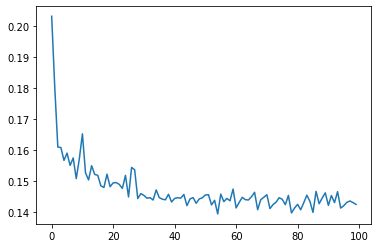

In [15]:
import matplotlib.pyplot as plt
root_folder = '/data/LiftFly3D/DF3D/cam_angles/cam15'

def read_convergence_info(file):
    f=open(file, "r")
    contents=f.readlines()
    epoch, lr, loss_train, loss_test, err_test = [], [], [], [], []
    for i in range(1,len(contents)):
        line = contents[i][:-1].split('\t')
        epoch.append(float(line[0]))
        lr.append(float(line[1]))
        loss_train.append(float(line[2]))
        loss_test.append(float(line[3]))
        err_test.append(float(line[4]))
        
    return epoch, lr, loss_train, loss_test, err_test

for cam in ['cam_0', 'cam_1', 'cam_2']:
    epoch, lr, loss_train, loss_test, err_test = read_convergence_info(root_folder + cam +'/log_train.txt')
    plt.plot(err_test,label=cam)
    
#plt.xscale('log')
plt.xlim([1, 100])
plt.ylabel('Training error')
plt.xlabel('Iterations')
plt.legend()
#plt.savefig('training_error.svg')

# Videos

In [2]:
import cv2
import numpy as np
import glob
import pickle
import matplotlib.pyplot as plt
from skeleton import skeleton
from matplotlib.animation import FFMpegWriter
import matplotlib
matplotlib.use("Agg")

Folders

In [11]:
experiment = '180919_MDN_CsCh_Fly6_001_SG1_behData_images'
root_folder = '/data/LiftFly3D/DF3D/data_DF3D/'
dims_to_consider = [i for i in range(38) if i not in [15,16,17,18,34,35,36,37]] 

Plot 2D stacked hourglass prediction on images and save as a 25fps video (4x slower)

In [12]:
G, color_edge = skeleton()
poses = pickle.load(open(root_folder + 'pose_result__data_paper_' + experiment + '.pkl', "rb"))
poses = poses['points2d']
poses = poses[:,:,dims_to_consider,:]
poses.shape

(7, 900, 30, 2)

/data/LiftFly3D/DF3D/data_DF3D/180919_MDN_CsCh_Fly6_001_SG1_behData_images/camera_5*.jpg


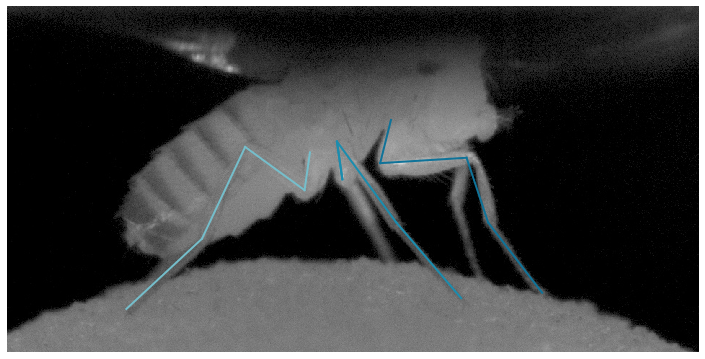

In [14]:
cam=5 #5 #run twice for cam 1 and 5

#load images
files = glob.glob(root_folder + experiment + '/' + 'camera_' + str(cam) + '*.jpg')
imgs = []
for f in sorted(files):
    img = cv2.imread(f)
    if cam == 5:
        img = np.fliplr(img)
    imgs.append(img)
    
assert imgs != [], 'no files found'    

fig = plt.figure(figsize=(9.6,4.8))
print(root_folder + experiment + '/' + 'camera_' + str(cam) + '*.jpg')
metadata = dict(title='camera_' + str(cam), artist='LiftFly3D', comment='Watch this!')
writer = FFMpegWriter(fps=25, metadata=metadata)
with writer.saving(fig, root_folder + experiment + "/camera_" + str(cam) + ".mp4", 100):
    for t in range(poses.shape[1]):
        plt.cla()
        
        plt.imshow(imgs[t])
        #plt.text(750, 450, 'Camera ' + str(cam), color='white', size=20)
        
        for i, j in enumerate(G.edges()): 
            x = np.array((poses[cam,t,j[0],0], poses[cam,t,j[1],0]))
            y = np.array((poses[cam,t,j[0],1], poses[cam,t,j[1],1]))
                   
            plt.plot(x, y, c=color_edge[i], alpha=1.0, linewidth = 2)    
            
        plt.axis('off')
        fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
        
        writer.grab_frame()

In [ ]:
#flip camera5 horizontally 
#ffmpeg -i camera_5.mp4 -vf hflip -c:a copy camera_5b.mp4

#stack videos vertically (call this in the folder where the images are)
#ffmpeg -i camera_1.mp4 -i camera_5b.mp4 -filter_complex vstack=inputs=2 stacked.mp4

#annotate
#ffmpeg -i stacked.mp4 -vf drawtext="fontfile=/home/gosztolai/Dropbox/github/fly_data_analysis/Liftfly3D/DF3D/helvetica.ttf: text='camera 1': fontcolor=white: fontsize=24: box=1: boxcolor=black@0.5: boxborderw=5: x=9*(w-text_w)/10: y=9*(h-text_h)/10/2" -codec:a copy stacked_b.mp4
#ffmpeg -i stacked_b.mp4 -vf drawtext="fontfile=/home/gosztolai/Dropbox/github/fly_data_analysis/Liftfly3D/DF3D/helvetica.ttf: text='camera 5': fontcolor=white: fontsize=24: box=1: boxcolor=black@0.5: boxborderw=5: x=9*(w-text_w)/10: y=9*(h-text_h)/10" -codec:a copy stacked_2b.mp4

#stack videos horizontally (call this in the folder where the images are)
#ffmpeg -i prediction_cams.mp4 -i stacked_2b.mp4 -filter_complex "[0:v]scale=-1:960[v0];[v0][1:v]hstack=inputs=2" output.mp4